# 02_STELLOPT_Boundary_Representations
Prepared by Caoxiang Zhu for group 2 of the Joint PPPL/Simons Summer School 2020

In fixed-boundary optimizations, [__STELLOPT__](https://princetonuniversity.github.io/STELLOPT/STELLOPT) varies the boundary coefficients to achieve target properties.
There are three boundary representations in STELLOPT: __VMEC representation__, __Hirshman-Breslau representation__ and __Garabedian representation__.
There is a brief webpage introducing these representations on the [VMECwiki](https://princetonuniversity.github.io/STELLOPT/STELLOPT%20Fixed%20Boundary%20Optimization).
Here, we are going to introduce them with more details and compare the optimization results using different representations.

## VMEC representation
### General description
The __VMEC representation__ is from the [VMEC](https://princetonuniversity.github.io/STELLOPT/VMEC) code.
A toroidal surface, $\cal{S}$, is represented in cylinder coordinates $(R, \phi, Z)$ as
$$ R = \sum R_{mn} \cos(m \theta -nN\phi) $$
$$ Z = \sum Z_{mn} \sin(m \theta -nN\phi) $$
Here, we assume that the surface has the so-called "_stellarator symmetry_", i.e. $R(-\theta, -\phi) = R(\theta, \phi)$ and $Z(-\theta, -\phi) = -Z(\theta, \phi)$. 
$N>0$ is the number of field periods. 
$\theta$ is a parametric angle variable and is usually called the poloidal angle, while the cylindrical angle $\phi$ is also called the toroidal angle.

The two arrays of VMEC coefficients, $R_{mn}$ and $Z_{mn}$, can now uniquely describe a toroidal surface (of course, if no stellarator symmetry is assumed, we need four arrays, both cosine and sine harmonics for R and Z). 
__The poloidal angle $\theta$ is not constrained, thus one can represent the same surface using different sets of Fourier coefficients.__

### Numerical details
In the `INDATA` namelist (for both VMEC and STELLOPT), the following variables are related to the VMEC representation.

| Variable name | Type | Description |
| ------------- | ---- | ----------- |
| NFP | integer | Number of toroidal field periods |
| LASYM | logical | Switch for stellarator symmetry, T: no; F: yes |
| MPOL | integer |Poloidal Mode Number (m) |
| NTOR | integer |Toroidal Mode Number (n) |
|RBC(N,M)       | real(-NTOR:NTOR, 0:MPOL)| Boundary cosine coefficients for R |
|ZBS(N,M)       | real(-NTOR:NTOR, 0:MPOL)| Boundary   sine coefficients for Z |
|RBS(N,M)       | real(-NTOR:NTOR, 0:MPOL)| Boundary cosine coefficients for R |
|ZBC(N,M)       | real(-NTOR:NTOR, 0:MPOL)| Boundary   sine coefficients for Z |

In the `OPTIMUM` namelist (for STELLOPT optimization), the variables __LBOUND_OPT(N,M)__ are used to control the boundary coefficients.
For example, if `LBOUND_OPT(-1,1) = T` is set, the RBC(-1,1) and ZBS(-1,1) parameters are varied during the optimization (`LASYM = F`). 
If `LASYM = T` in `INDATA`, then RBS(-1,1) and ZBC(-1,1) are also free variables. 
The corresponding BOUND variables are __RBC_MIN(N,M)__, __RBC_MAX(N,M)__, etc.


## Hirshman-Breslau representation
### General description
The Hirshman-Breslau representation is introduced in [Hirshman, S. P., & Breslau, J. (1998). Physics of Plasmas, 5(7)](https://aip.scitation.org/doi/abs/10.1063/1.872954). In that paper, Hirshman & Breslau introduced two unqiue representations to provide additional contraints on the poloidal angle. The one used in STELLOPT is the so-called "quasi-polar"representation. It uses an effective (quasipolar) "radius" $\rho$ as the only coordinate.
$$ \rho =  \sum \rho^c_{mn} \cos(m \theta -nN\phi) + \rho^s_{mn} \sin(m \theta -nN\phi)$$
$$ r = \rho \cos(\theta)$$
$$ z = \rho \sin(\theta)$$

The implemention of Hirshman-Breslau representation in STELLOPT is introduced Sec. IV.B in that paper. For a given set of $RBC$ and $ZBS$ (only avalid for stellarator symmetry and only $\rho^s_{mn}$ is used), the covert is carried out as
$$ m=0,1 \quad \rho(n,m) = \frac{1}{2} \left [\frac{RBC(n,m+1)+ZBS(n,m+1)}{t_1(m+1)} \right ] $$
$$ m\geq2 \quad \rho(n,m) = \frac{1}{4} \left[\frac{RBC(n,m+1)+ZBS(n,m+1)}{t_1(m+1)} + \frac{RBC(n,m-1)+ZBS(n,m-1)}{t_2(m-1)}\right] $$

where $t_1(m) = (\frac{m-1}{m})^p$, $t_2(m) = (\frac{m+1}{m})^p$. The exponential index $p$ can improve the convergence. $p=0$ is the polar representation and $p=1$ is the equal arc-length representation. Normally, $p=4$ is a good value. 

__The Hirshman-Breslau representation has a unique poloidal angle.__

### Numerical details
In order to use the  Hirshman-Breslau representation, the user has to specify `LRHO_OPT(N,M) = T` in the input file.
The exponential term $p$ in the paper is determined by `RHO_EXP` in the namelist.
If the user wishes STELLOPT to vary the `m=0` modes, the `LBOUND_OPT(N,0)` modes should be set to true (ignoring the N=0 mode).

When using the Hirshman-Breslau representation, STELLOPT will first read `RBC` and `ZBS` terms in the input file and then convert the boundary using the subroutine [convert_boundary](https://github.com/PrincetonUniversity/STELLOPT/blob/develop/LIBSTELL/Sources/Miscel/convert_boundary.f).
One should note the conversion is not guaranteed to be accurate. 
STELLOPT will also write a file `rhomn.txt` containing the boundary parameters.

## Garabedian representation
### General description
The [Garabedian representation](http://www.pnas.org/content/95/17/9732.long) packs $R$ and $Z$ into a complex number
$$ R + iZ = e^{2\pi iu} \sum \Delta_{mn} e^{-2\pi i (mu-nv)} .$$
Here, $R$ and $Z$ are the radial and axial components of cylindrical coordinates, $m$ and $n$ are the poloidal and toroidal mode numbers, and $u$ and $v$ are the normalized poloidal and toroidal angle-like variables, $0 \leq u< 1$ and $0 \leq v< 1$ ($2\pi u = \theta,2\pi v /N = \phi$, $\theta$ and $\phi$ being the poloidal and toroidal angles, respectively).

In this notation, the coefficient $\Delta_{00}$ is a measure of the plasma minor radius and $\Delta_{10}$ the major radius. It's usually imposed the normalization $\Delta_{00}=1.0$ on the small plasma radius. Conformal mapping shows that shape factors $\Delta_{mn}$ with large negative $m$ cause unrealistic cusps to penetrate the plasma, so we choose to leave them out when $m<-1$. The terms with $m =−1$, which define catenoids or crescents, are helpful because they contribute significantly to the magnetic well. Analytic geometry shows that the coefficients $\Delta_{1n}$ specify the helical excursion of the magnetic axis, whereas $\Delta_{2n}$ makes the plasma shape elliptical, $\Delta_{3n}$ makes it triangular, $\Delta_{4n}$ makes it rectangular, and so forth. Experience with the computations establishes that each $\Delta_{mn}$ has a strong influence on the corresponding coefficient Bmn in the magnetic spectrum, which makes it easier to design stellarators with approximate two-dimensional symmetry.

In Garabedian representation, the poloidal angle $u$ (or $\theta$) is not unique. Improved zoning can be obtained by performing an additional substitution $ u = u_1 - \sum Z_{mn} \sin(mu_1-nv) $ on the poloidal angle $u$. __The poloidal angle in the Garabedian representation is not unique.__

### Numerical details
In order to use the Garabedian representation, the user has to specify `LDELTAMN_OPT(N,M) = T` in the input file.

When using the Garabedian representation, STELLOPT will first read `RBC` and `ZBS` terms in the input file and then convert the boundary using the subroutine [convert_boundary_PG](https://github.com/PrincetonUniversity/STELLOPT/blob/develop/LIBSTELL/Sources/Miscel/convert_boundary_PG.f).
STELLOPT will also write a file `deltamn.txt` containing the boundary parameters.

## Comparisons
In the folder, we have three cases in `./vmec/`, `./hb/`, and `./gb/`.
They are from the same boundary and have the same targets.
The only difference is that they use different surface representations during the optimization.
The goal of this experiment is to preliminarily explore the difference in the three surface representations.

You can simply run the following commands in the terminal.
```shell
cd ./vmec
mpiexec -n 8 xstelloptv2 input.qas_vmec
```

It will take about 20 mins to finish.
You can also use more CPUs to accelerate or use fewer CPUs if many people are running code simultaneously.
Once finished, you can check the results.

In [1]:
# import required packages
# Please update coilpy by typing `pip install -U coilpy` before importing
import matplotlib.pyplot as plt
import numpy as np
from coilpy import *

In [ ]:
cd ./vmec

### Check STELLOPT results

Now we can check the STELLOPT results.
The main output is `stellopt.all` file in which STELLOPT writes the status of each iteration.
We can read this file by using the python code [`coilpy.STELLout` ](https://github.com/zhucaoxiang/CoilPy/blob/master/coilpy/stellopt.py), or something else you like.

In [ ]:
# read the ooutput
stell_all = STELLout('stellopt.all')

In [ ]:
# plot the convergence
stell_all.plot()

### Check the VMEC equilibrium

For each successiful iteration, STELLOPT will save the VMEC output (and the results from other codes as well).
You can check the status of VMEC equilibrium at each iteration.
```
ls -al wout_*
```

In [ ]:
# Read the initial VMEC output file
init = VMECout('wout_all.00000.nc')

In [ ]:
# Check the flux surface shape
init.plot('LPK')

In [ ]:
# Check iota profile
init.plot('iota')
# Check Pressure profile
init.plot('pressure')

In [ ]:
# compare two VMEC equilibrium
final = VMECout('wout_reset_file.nc')
plt.figure()
init.surface[-1].plot(zeta=0, color='b', linestyle='--', label='initial')
init.surface[-1].plot(zeta=np.pi/3, color='b', linestyle='--')
final.surface[-1].plot(zeta=0, color='r', linestyle='-', label='final')
final.surface[-1].plot(zeta=np.pi/3, color='r', linestyle='-')
plt.legend()

### Hirshman-Breslau representation not accurately converted
When STELLOPT first converts `RBC` and `ZBS` into the Hirshman-Breslau representation.
It is likely the boundary shape will be changed.
For example, `./hb/input.qas_hb_exp1.00000` is obtained by convert `RBC` into `rhomn` (with `rho_exp=1`) and then convert back to run VMEC.
We can compare the flux surface shapes in the two input files.

In [6]:
# read VMEC input files into a Fourier surface
original = FourSurf.read_vmec_input('./hb/input.qas_hb')
converted = FourSurf.read_vmec_input('./hb/input.qas_hb_exp1.00000')

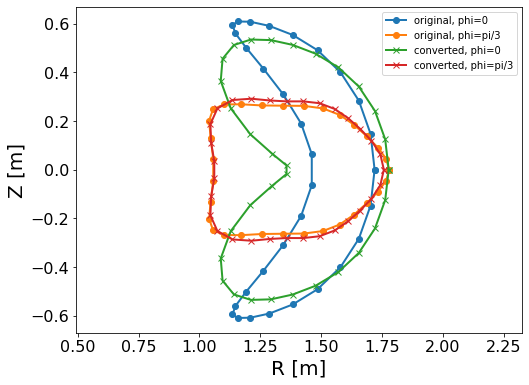

In [10]:
# plot the boundary shape
plt.figure(figsize=(8,6))
original.plot(npoints=32, marker='o', label='original, phi=0')
original.plot(zeta=np.pi, npoints=32, marker='o', label='original, phi=pi/3')
converted.plot(npoints=32, marker='x', label='converted, phi=0')
converted.plot(zeta=np.pi, npoints=32, marker='x', label='converted, phi=pi/3')
plt.legend()

$p=1$ in the Hirshman-Breslau representation is also called "equal-arc" angle.
Looking at the above figure, you can see the "converted" angle is indeed somehow "equal-arc".
In the file `./hb/input.qas_hb`, we are using `rho_exp=4` and the difference after conversion is small.

Now please compare all the three cases.